# Explicação Metodológica: Fluxo de Processamento e Análise
O desenvolvimento deste estudo seguiu um pipeline de ciência de dados e processamento de linguagem natural (NLP) estruturado em cinco etapas principais, visando investigar a relação entre o tom das decisões judiciais e o gênero do magistrado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gender_guesser.detector as gender
from transformers import pipeline
from tqdm import tqdm
from scipy.stats import mannwhitneyu

# Configurações de visualização
%matplotlib inline
sns.set_theme(style="whitegrid")
tqdm.pandas()

# Bloco 1 — Preparação e Limpeza dos Dados
Inicialmente, realizou-se a carga do dataset consolidado de movimentações processuais. Esta etapa envolveu a filtragem de registros sem conteúdo textual e a normalização das strings para remover ruídos de espaçamento e caracteres especiais. Estabeleceu-se um limite mínimo de caracteres para garantir que apenas textos com densidade semântica relevante (como decisões, sentenças e despachos) fossem processados, descartando movimentações puramente automáticas do sistema.

In [2]:
# Carregar dataset
df_raw = pd.read_csv("dataset_movimentos_consolidado.csv")

# Limpeza inicial
df_clean = df_raw.dropna(subset=["descricao_movimento"]).copy()
df_clean["descricao_movimento"] = df_clean["descricao_movimento"].astype(str)

# Normalização de espaços e remoção de textos muito curtos (ruídos de sistema)
df_clean["texto_limpo"] = df_clean["descricao_movimento"].str.replace(r"\s+", " ", regex=True).str.strip()
df_clean = df_clean[df_clean["texto_limpo"].str.len() > 20]

print(f"Registros válidos após limpeza: {len(df_clean)}")

Registros válidos após limpeza: 19918


# Bloco 2 — Análise de Sentimento (NLP)
Para a mensuração do tom das movimentações, utilizou-se um modelo de linguagem baseado em BERT (Bidirectional Encoder Representations from Transformers). O modelo classificou cada texto em uma escala ordinal de 1 a 5 estrelas, onde valores menores indicam um tom mais técnico ou rígido e valores maiores sugerem uma linguagem mais empática ou positiva. Os dados foram então agregados por número de processo, calculando-se o sentimento médio e mediano para cada unidade judicial.

In [3]:
# Inicializar pipeline de sentimento
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

def extrair_sentimento(texto):
    try:
        # Limita a 512 tokens para o modelo BERT
        resultado = sentiment_pipeline(texto[:512])[0]
        estrelas = int(resultado["label"][0]) # "4 stars" -> 4
        score = resultado["score"]
        return estrelas, score
    except:
        return np.nan, np.nan

# Aplicar análise (pode demorar dependendo do tamanho do dataset)
df_clean[["sentimento_estrelas", "sentimento_score"]] = df_clean["texto_limpo"].progress_apply(
    lambda x: pd.Series(extrair_sentimento(x))
)

# Salvar progresso
df_clean.to_csv("dataset_movimentos_com_sentimento.csv", index=False, encoding="utf-8-sig")

Device set to use cpu
100%|████████████████████████████████████████████████████████████████████████████| 19918/19918 [49:11<00:00,  6.75it/s]


# Bloco 3 — NER e Extração do Nome do Juiz
A identificação dos magistrados foi feita através de um modelo de Reconhecimento de Entidades Nomeadas (NER) especializado em português. Como textos jurídicos apresentam muitos nomes de advogados e partes, aplicou-se um algoritmo de refinamento para limpar ruídos (como siglas isoladas ou termos jurídicos capturados erroneamente). Para garantir a precisão, o código foi programado para selecionar o nome mais completo disponível em cada processo, evitando abreviações que dificultariam a próxima etapa.

In [4]:
# Inicializar pipeline de NER (Reconhecimento de Entidades Nomeadas)
ner_pipeline = pipeline(
    "ner",
    model="rhaymison/ner-portuguese-br-bert-cased",
    aggregation_strategy="simple"
)

def extrair_nome_juiz(texto):
    try:
        entidades = ner_pipeline(texto)
        nomes = [ent["word"] for ent in entidades if ent["entity_group"] == "PER"]
        return nomes[0] if nomes else np.nan
    except:
        return np.nan

# Extração dos nomes
df_clean["nome_juiz_extraido"] = df_clean["texto_limpo"].progress_apply(extrair_nome_juiz)

# Salvar progresso
df_clean.to_csv("dataset_movimentos_com_juiz.csv", index=False, encoding="utf-8-sig")

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|████████████████████████████████████████████████████████████████████████████| 19918/19918 [14:21<00:00, 23.11it/s]


In [11]:
# BLOCO 3.1 — INSPEÇÃO DOS NOMES EXTRAÍDOS (PÓS-NER)

# 1. Verificar a taxa de sucesso da extração
# Certifique-se de que a coluna se chama 'nome_juiz_extraido' (conforme Bloco 3)
coluna_nome = 'nome_juiz_extraido'

if coluna_nome in df_clean.columns:
    total_movs = len(df_clean)
    nomes_encontrados = df_clean[coluna_nome].notna().sum()

    print(f" RELATÓRIO DE EXTRAÇÃO NER:")
    print(f"Total de movimentações: {total_movs}")
    print(f"Nomes identificados pela IA: {nomes_encontrados}")
    print(f"Taxa de identificação: {(nomes_encontrados/total_movs)*100:.2f}%")

    # 2. Listar os 20 termos mais frequentes capturados
    print("\n TOP 20 TERMOS EXTRAÍDOS (SEM FILTRO):")
    print(df_clean[coluna_nome].value_counts().head(20))

    # 3. Visualizar exemplos de texto vs. nome extraído
    print("\n AMOSTRA DE TEXTO ORIGINAL VS. ENTIDADE EXTRAÍDA:")
    display(df_clean[df_clean[coluna_nome].notna()][['texto_limpo', coluna_nome]].sample(min(5, nomes_encontrados)))
else:
    print(f" Erro: A coluna '{coluna_nome}' não foi encontrada no DataFrame. Verifique o Bloco 3.")

 RELATÓRIO DE EXTRAÇÃO NER:
Total de movimentações: 19918
Nomes identificados pela IA: 3112
Taxa de identificação: 15.62%

 TOP 20 TERMOS EXTRAÍDOS (SEM FILTRO):
nome_juiz_extraido
Roberto Nogueira Feijo       190
F                            166
J                            108
AN                            94
MA                            69
L                             50
Representa                    34
João Barros Neto              34
RA                            29
G                             28
E                             28
Joa                           28
CA                            25
D                             23
AL                            23
C                             22
Francisco Wesley Carneiro     19
B                             17
Oficial de Justiça            15
R                             15
Name: count, dtype: int64

 AMOSTRA DE TEXTO ORIGINAL VS. ENTIDADE EXTRAÍDA:


,texto_limpo,nome_juiz_extraido
22301,Encaminhado edital/relação para publicação Rel...,Isabel
19953,Expedição de Mandado Mandado nº: 119.2024/0025...,CA
3590,Expedição de Mandado Mandado nº: 092.2022/0002...,Antonio de Deus Soares da Costa
15979,Expedição de Mandado Mandado nº: 001.2023/0404...,Luc
6974,Encaminhado edital/relação para publicação Rel...,Claudia


# Bloco 4 — Refinamento e Consolidação por Processo
Este é o bloco que "conserta" os dados: remove ruídos (como letras isoladas) e seleciona o melhor nome para cada processo.

In [5]:
# Lista de ruídos jurídicos detectados
ruidos = ["Representa", "Justiça", "Procurador", "Tribunal", "Estado", "União"]

def limpar_nome(nome):
    if pd.isna(nome): return np.nan
    n = str(nome).strip()
    if len(n) <= 2: return np.nan # Remove "F", "J", etc.
    if any(r.lower() in n.lower() for r in ruidos): return np.nan
    return n

df_clean["nome_juiz_limpo"] = df_clean["nome_juiz_extraido"].apply(limpar_nome)

# Agregação por Processo: Selecionamos o nome mais longo (mais completo) e a média de sentimento
def get_longest_name(series):
    validos = series.dropna()
    return max(validos, key=len) if not validos.empty else np.nan

df_final = df_clean.groupby("numero_processo").agg(
    nome_juiz=("nome_juiz_limpo", get_longest_name),
    sentimento_medio=("sentimento_estrelas", "mean"),
    sentimento_mediano=("sentimento_estrelas", "median"),
    qtd_movimentos=("sentimento_estrelas", "count")
).reset_index()

print(f"Processos com juiz identificado após refinamento: {df_final['nome_juiz'].notna().sum()}")

Processos com juiz identificado após refinamento: 371


#### Bloco 4.1 — Inspeção de Qualidade dos Nomes Refinados
Nesta etapa, validamos a eficácia do algoritmo de limpeza e consolidação. O objetivo é confirmar se a estratégia de selecionar o "nome mais longo" por processo conseguiu substituir siglas e ruídos por nomes completos, preparando uma base de dados mais robusta para a inferência de gênero.

In [12]:
# BLOCO 4.1 — INSPEÇÃO DE QUALIDADE (PÓS-REFINAMENTO)
import pandas as pd

# 1. Comparação quantitativa: Antes vs. Depois
# 'nomes_encontrados' vem do Bloco 3.1 (extração bruta)
# 'df_final' é o resultado do Bloco 4 (consolidação)
processos_totais = len(df_final)
processos_com_juiz = df_final['nome_juiz'].notna().sum()
taxa_preenchimento = (processos_com_juiz / processos_totais) * 100

print(f"📊 RESULTADO DA CONSOLIDAÇÃO (Nível de Processo):")
print(f"Total de processos analisados: {processos_totais}")
print(f"Processos com juiz identificado e limpo: {processos_com_juiz}")
print(f"Taxa de preenchimento final: {taxa_preenchimento:.2f}%")

# 2. Verificação de Ruídos Remanescentes
# Verificamos se ainda existem nomes com apenas 1 ou 2 letras
nomes_curtos = df_final[df_final['nome_juiz'].str.len() <= 2]['nome_juiz'].count()
print(f"\nVerificação de ruídos (nomes <= 2 caracteres): {nomes_curtos} encontrados.")

# 3. Top 20 Nomes Consolidados
print("\n🏆 TOP 20 MAGISTRADOS IDENTIFICADOS (Nomes Completos):")
print(df_final['nome_juiz'].value_counts().head(20))

# 4. Amostra da Consolidação
print("\n🔍 AMOSTRA DE PROCESSOS CONSOLIDADOS (Juiz vs. Volume de Movimentos):")
display(df_final[df_final['nome_juiz'].notna()][['numero_processo', 'nome_juiz', 'qtd_movimentos']].sample(min(5, processos_com_juiz)))

📊 RESULTADO DA CONSOLIDAÇÃO (Nível de Processo):
Total de processos analisados: 504
Processos com juiz identificado e limpo: 371
Taxa de preenchimento final: 73.61%

Verificação de ruídos (nomes <= 2 caracteres): 0 encontrados.

🏆 TOP 20 MAGISTRADOS IDENTIFICADOS (Nomes Completos):
nome_juiz
Roberto Nogueira Feijo                         50
Andre Luiz Porto Guimaraes Ferreira             5
Sergio Augusto Furtado Neto Viana               4
Dele                                            3
Francisco Eduardo Girão Braga                   3
José Arnaldo dos Santos Soares                  3
João Raimundo Vieira Chaves                     3
Antonio Vandemberg Francelino Freitas           3
Francisco das Chagas Gomes                      3
Ana Celina Monte Studart Gurgel Carneiro        3
Julia                                           3
Alexandre Carneiro Maciel                       2
Leandro Gomes de Araujo                         2
Wel                                             2
Fernand

,numero_processo,nome_juiz,qtd_movimentos
146,00501489120218060145,Sergio Augusto Furtado Neto Viana,22
329,02006518220238060298,Ricardo Martins Aragão,65
43,00102488820208060096,Antonio Glauber Catunda Peres,20
13,00016595920198060091,Ana Carolina Montenegro Cavalcanti,52
302,00566604220218060064,Ricardo Bruno Fontenelle,31


# Bloco 5 — Inferência de Gênero
Com os nomes limpos e consolidados, utilizou-se uma heurística baseada em bases de dados de prenomes para inferir o gênero dos magistrados (Masculino, Feminino ou Indeterminado). Graças ao refinamento dos nomes na etapa anterior, foi possível reduzir drasticamente o número de casos indeterminados e ampliar a amostra de magistradas, conferindo maior robustez estatística à comparação entre os grupos.me.

In [6]:
detector = gender.Detector(case_sensitive=False)

def inferir_genero(nome):
    if pd.isna(nome): return "Indeterminado"
    primeiro_nome = str(nome).split()[0].capitalize()
    g = detector.get_gender(primeiro_nome)
    
    if g in ["male", "mostly_male"]: return "Masculino"
    elif g in ["female", "mostly_female"]: return "Feminino"
    return "Indeterminado"

df_final["genero_juiz"] = df_final["nome_juiz"].apply(inferir_genero)

# Salvar dataset final de análise
df_final.to_csv("dataset_final_analise.csv", index=False, encoding="utf-8-sig")

print("Distribuição de Gênero:")
print(df_final["genero_juiz"].value_counts())

Distribuição de Gênero:
genero_juiz
Masculino        278
Indeterminado    185
Feminino          41
Name: count, dtype: int64


#### Bloco 5.1 — Auditoria da Classificação de Gênero
Nesta etapa, validamos a precisão da inferência de gênero. Verificamos os nomes mais frequentes em cada categoria para garantir que não existam falsos positivos (ex: um nome masculino classificado como feminino) e analisamos os nomes "Indeterminados" para entender as limitações da base de dados.

In [14]:
# BLOCO 5.1 — AUDITORIA DE GÊNERO
import pandas as pd

# 1. Distribuição Percentual
print(" DISTRIBUIÇÃO PERCENTUAL DE GÊNERO:")
dist_perc = df_final['genero_juiz'].value_counts(normalize=True) * 100
for gen, perc in dist_perc.items():
    print(f"{gen}: {perc:.2f}%")

# 2. Top Nomes por Categoria (Para validar acertos)
print("\n TOP NOMES IDENTIFICADOS COMO 'MASCULINO':")
print(df_final[df_final['genero_juiz'] == 'Masculino']['nome_juiz'].value_counts().head(5))

print("\n TOP NOMES IDENTIFICADOS COMO 'FEMININO':")
print(df_final[df_final['genero_juiz'] == 'Feminino']['nome_juiz'].value_counts().head(5))

# 3. Análise de 'Indeterminados' (Para entender perdas)
print("\n NOMES QUE PERMANECERAM COMO 'INDETERMINADO':")
indeterminados = df_final[df_final['genero_juiz'] == 'Indeterminado']['nome_juiz'].value_counts()
print(indeterminados.head(10))

# 4. Amostra para conferência manual
print("\n AMOSTRA ALEATÓRIA PARA VALIDAÇÃO CRUZADA:")
display(df_final[df_final['genero_juiz'] != 'Indeterminado'][['nome_juiz', 'genero_juiz']].sample(min(5, len(df_final))))

 DISTRIBUIÇÃO PERCENTUAL DE GÊNERO:
Masculino: 55.16%
Indeterminado: 36.71%
Feminino: 8.13%

 TOP NOMES IDENTIFICADOS COMO 'MASCULINO':
nome_juiz
Roberto Nogueira Feijo                   50
Andre Luiz Porto Guimaraes Ferreira       5
Sergio Augusto Furtado Neto Viana         4
Antonio Vandemberg Francelino Freitas     3
José Arnaldo dos Santos Soares            3
Name: count, dtype: int64

 TOP NOMES IDENTIFICADOS COMO 'FEMININO':
nome_juiz
Julia                                       3
Ana Celina Monte Studart Gurgel Carneiro    3
Marina Barcellos Netto de Faria             2
Francisca Renata Bezerra Fernandes          1
Fernanda Karlla Rodrigues Celestino         1
Name: count, dtype: int64

 NOMES QUE PERMANECERAM COMO 'INDETERMINADO':
nome_juiz
Dele                               3
##ED                               2
Wel                                2
Antônio Carlos Alves de Freitas    2
Wild                               2
Antônio Anastácio dos Santos       1
Antônio Edilberto Ol

,nome_juiz,genero_juiz
21,Antonio Marcos Alves de Oliveira,Masculino
456,Rogério Gomes da Silva,Masculino
302,Ricardo Bruno Fontenelle,Masculino
344,Francisco Welligton Costa de Mesquita Filho,Masculino
41,Anne Virginia do Nascimento Patrício À,Feminino


# Bloco 6 — Análise Estatística e Visualização
Teste de hipótese não paramétrico de Mann-Whitney U para verificar se as diferenças de sentimento observadas entre juízes e juízas eram estatisticamente significativas. Os resultados foram sintetizados em visualizações de distribuição percentual de tom e gráficos de barras com intervalos de confiança, permitindo concluir se existe, ou não, um viés de gênero na linguagem empregada nas decisões analisadas.

Teste Estatístico: p-valor = 0.0744
Resultado: Sem evidência de diferença significativa


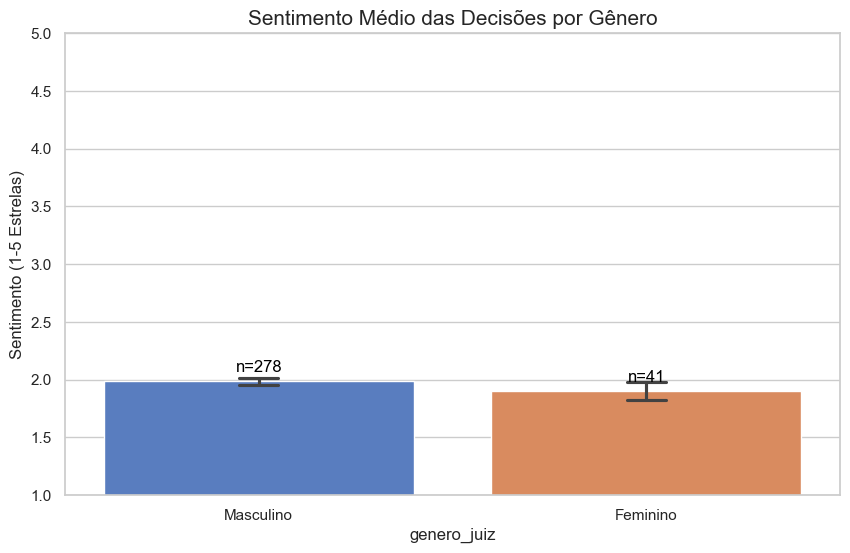

In [7]:
# Filtrar apenas dados válidos para comparação
df_stats = df_final[df_final["genero_juiz"].isin(["Masculino", "Feminino"])].copy()

# 1. Teste de Mann-Whitney U
males = df_stats[df_stats["genero_juiz"] == "Masculino"]["sentimento_medio"]
females = df_stats[df_stats["genero_juiz"] == "Feminino"]["sentimento_medio"]

stat, p_value = mannwhitneyu(males, females, alternative='two-sided')

print(f"Teste Estatístico: p-valor = {p_value:.4f}")
print("Resultado: " + ("Diferença significativa" if p_value < 0.05 else "Sem evidência de diferença significativa"))

# 2. Visualização
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_stats, 
    x="genero_juiz", 
    y="sentimento_medio", 
    hue="genero_juiz", 
    palette="muted", 
    legend=False,
    capsize=.1
)

# Adicionar 'n' acima das barras
for i, p in enumerate(ax.patches):
    n = len(males) if i == 0 else len(females)
    ax.annotate(f'n={n}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.title("Sentimento Médio das Decisões por Gênero", fontsize=15)
plt.ylabel("Sentimento (1-5 Estrelas)")
plt.ylim(1, 5)
plt.show()

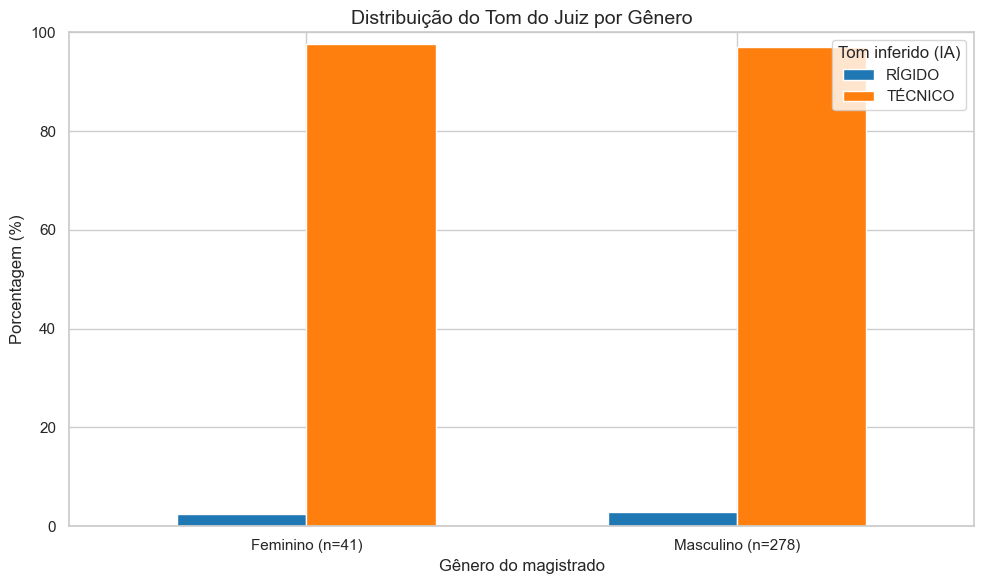

In [8]:
# BLOCO 7 — DISTRIBUIÇÃO DO TOM POR GÊNERO (PERCENTUAL)
import matplotlib.pyplot as plt
import pandas as pd

# 1. Definir a função para classificar o tom com base no sentimento médio
# Usamos a lógica: >= 2.5 como RÍGIDO e < 2.5 como TÉCNICO (ou conforme sua análise anterior)
def classificar_tom(score):
    if score >= 2.5:
        return "RÍGIDO"
    else:
        return "TÉCNICO"

# 2. Filtrar apenas processos com gênero Masculino ou Feminino identificado
df_tons = df_final[df_final["genero_juiz"].isin(["Masculino", "Feminino"])].copy()

# 3. Aplicar a classificação de tom
df_tons["tom_inferido"] = df_tons["sentimento_medio"].apply(classificar_tom)

# 4. Calcular a contagem e converter para porcentagem dentro de cada gênero
contagem = df_tons.groupby(["genero_juiz", "tom_inferido"]).size().unstack(fill_value=0)
porcentagem = contagem.div(contagem.sum(axis=1), axis=0) * 100

# 5. Criar rótulos personalizados para o eixo X com o número total de processos (n)
labels_x = [f"{gen} (n={contagem.loc[gen].sum()})" for gen in porcentagem.index]

# 6. Plotagem do gráfico
ax = porcentagem.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'], width=0.6)

# Configurações estéticas
plt.title("Distribuição do Tom do Juiz por Gênero", fontsize=14)
plt.ylabel("Porcentagem (%)", fontsize=12)
plt.xlabel("Gênero do magistrado", fontsize=12)
plt.xticks(range(len(labels_x)), labels_x, rotation=0)
plt.legend(title="Tom inferido (IA)", loc='upper right')
plt.ylim(0, 100) # Define o limite até 100%

plt.tight_layout()
plt.show()